# Transfer

### Fine-tune

In [1]:
from data.tal import TALDataModule
from models.model_pool import GNNModule
import pytorch_lightning as pl
import torch

EPOCHS = 5
BATCH_SIZE = 16
KNOWN_PERCENT = 0.9

torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.set_float32_matmul_precision('medium')

# Logger for the specific configuration
tb_logger = pl.loggers.TensorBoardLogger(
    save_dir="logs/final/", 
    name=f"tal"
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    )


# Trainer setup
trainer = pl.Trainer(
    logger=tb_logger,
    max_epochs=EPOCHS,
    enable_progress_bar=True,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    fast_dev_run=False,
)


model = GNNModule.load_from_checkpoint("models/saved/final/checkpoints/epoch=99-step=35500.ckpt")
model.fine_tuning = True
model.freeze()

datamodule = TALDataModule(
    environmental_param="gas",
    seq_len=10,
    num_workers=5,
    batch_size=BATCH_SIZE,
    shuffle=True,
    p_sensor=KNOWN_PERCENT,
)

# Train the model
trainer.fit(model, datamodule)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nwinkler/miniforge3/envs/gnn/lib/python3.12/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([_unpickle_timestamp])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | GNN     | 104 K  | train
1 | loss_fn | MSELoss | 0      | train
---------------------------------

Epoch 4: 100%|██████████| 514/514 [00:56<00:00,  9.13it/s, v_num=0, train_loss_step=0.0156, val_loss=0.0152, train_loss_epoch=0.0114] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 514/514 [00:56<00:00,  9.12it/s, v_num=0, train_loss_step=0.0156, val_loss=0.0152, train_loss_epoch=0.0114]


# Test

## LOOCV

In [1]:
import torch
from data.tal import TALDataset
from torch_geometric.loader import DataLoader
from models.model_pool import GNNModule

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model_baseline = GNNModule.load_from_checkpoint("models/saved/final/checkpoints/epoch=99-step=35500.ckpt", map_location=device)
model_tuned = GNNModule.load_from_checkpoint("models/saved/final_tal/checkpoints/epoch=4-step=2570.ckpt", map_location=device)
model_tuned.eval()
model_baseline.eval()

dataset = TALDataset("data/tal", environmental_param="gas", type="test", p_sensor=1) 
dataloader = DataLoader(dataset, batch_size=1)

/home/nwinkler/miniforge3/envs/gnn/lib/python3.12/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([_unpickle_timestamp])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [2]:
from tqdm import tqdm
from utils.loocv import remove_node, get_idx_of_nearest_virtual_1d, get_idx_of_nearest_virtual_2d
from models.sota.kernel_dmv.wrapper import KernelDMV

CELL_SIZE = 2
X_RANGE = [0,120]
Y_RANGE = [0,20]

# Load KDM+V
model_kdm = KernelDMV(x_range=X_RANGE, y_range=Y_RANGE, cell_size=CELL_SIZE, kernel_size=2.5)

rmse_baseline = []
rmse_tuned = []
rmse_kdm = []

n_samples = len(dataset)
for i in tqdm(range(n_samples)):
    data = dataset[i]

    #~~~~~~~~~~~~~~~~~~~~
    # Drop a random node
    #~~~~~~~~~~~~~~~~~~~~
    # Select a random node to drop
    rand_idx = torch.randperm(data.id[data.sensor].size(0))[:1]

    # ID, value, and position of dropped node
    dropped_id = data.id[data.sensor][rand_idx]
    dropped_val = data.y[data.sensor][rand_idx][0][-1]
    dropped_pos = data.orig_pos[data.sensor][rand_idx]

    # Actually drop the node from the data object
    data_dropped = remove_node(data, rand_idx)

    #~~~~~~~~~~~~~~~~~~~~
    # Predict
    #~~~~~~~~~~~~~~~~~~~~
    with torch.no_grad():
        pred = model_baseline(data_dropped.to(device))
        pred_tuned = model_tuned(data_dropped.to(device))

    # KernelDMV
    data_dropped.to('cpu')
    x = data_dropped.x[data_dropped.sensor][:,-1] # filter sensors &only keep the last time step
    pos = data_dropped.orig_pos[data_dropped.sensor]
    model_kdm.set_measurements(pos, x)
    pred_kdm = model_kdm.predict()

    #~~~~~~~~~~~~~~~~~~~~
    # Calculate difference
    #~~~~~~~~~~~~~~~~~~~~
    # GNN
    idx = get_idx_of_nearest_virtual_1d(dropped_pos, data_dropped)
    pred_val = pred[idx].squeeze()
    pred_tuned_val = pred_tuned[idx].squeeze()

    # KDM
    nearest_x_idx, nearest_y_idx = get_idx_of_nearest_virtual_2d(dropped_pos, X_RANGE, Y_RANGE, CELL_SIZE)
    pred_kdm_val = pred_kdm[nearest_x_idx, nearest_y_idx]

    rmse_baseline.append(abs(pred_val - dropped_val))
    rmse_tuned.append(abs(pred_tuned_val - dropped_val))
    rmse_kdm.append(abs(pred_kdm_val - dropped_val))

print(f"RMSE Baseline: {sum(rmse_baseline)/n_samples}")
print(f"RMSE Tuned: {sum(rmse_tuned)/n_samples}")
print(f"RMSE KDM: {sum(rmse_kdm)/n_samples}")

  0%|          | 0/8213 [00:00<?, ?it/s]/home/nwinkler/miniforge3/envs/gnn/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 8213/8213 [02:12<00:00, 61.76it/s]

RMSE Baseline: 0.4487326443195343
RMSE Tuned: 0.21994781494140625
RMSE KDM: 0.5370838598242327


**KDM kernel size = 2.5**  
RMSE Baseline: 0.4487326443195343  
RMSE Tuned: 0.21994781494140625  
RMSE KDM: 0.5370838598242327  


**KDM kernel size = 5**  
RMSE Baseline: 0.4437406361103058  
RMSE Tuned: 0.21416442096233368  
RMSE KDM: 0.46042975761178884


**KDM kernel size = 10**  
RMSE Baseline: 0.4508286714553833  
RMSE Tuned: 0.21639636158943176  
RMSE KDM: 0.34002339997632186


**KDM kernel size=15**  
RMSE Baseline: 0.44994106888771057  
RMSE Tuned: 0.21623846888542175  
RMSE KDM: 0.3614542786190213


# Visualize

In [1]:
import matplotlib.pyplot as plt
from models.model_pool import GNNModule

def load_models(model_paths, device):
    """
    Load models from a list of checkpoint paths.
    Args:
        model_paths (list): List of model checkpoint paths.
        device (str): Device to map the models to.
    Returns:
        list: List of loaded models.
    """
    models = []
    for path in model_paths:
        model = GNNModule.load_from_checkpoint(path, map_location=device)
        model.eval()
        models.append(model)
    return models

def plot_graph(data, pred, vmin=None, vmax=None, node_size=20):
    pos = data.orig_pos.flip(0).numpy()
    plt.scatter(
        pos[:, 0], pos[:, 1],
        s=node_size,  # node size
        c=pred.flip(0),
        cmap=plt.cm.viridis,
        vmin=vmin,
        vmax=vmax,
    )

    plt.scatter(
        pos[data.sensor.flip(0), 0], pos[data.sensor.flip(0), 1],
        s=node_size,
        facecolors='none',
        edgecolors='red',
        linewidth=.3
    )

    plt.axis('scaled')
    plt.xlim(pos[:, 0].min()-1.5, pos[:, 0].max()+1.5)
    # plt.ylim(pos[:, 1].min(), pos[:, 1].max())
    plt.xlabel('X Position [m]')
    plt.ylabel('Y Position [m]')
    
    plt.tight_layout()
    # plt.show()

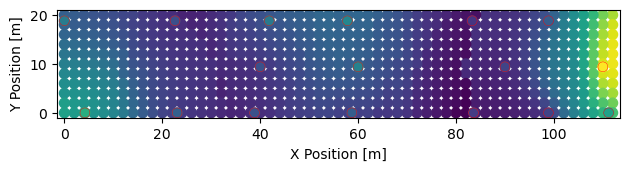

In [3]:
from data.tal import TALDataset
from datetime import datetime
import torch
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

CELL_SIZE = 2

# Dataset
dataset = TALDataset("data/tal", environmental_param="gas", type="test", p_sensor=1) 
data = dataset.get_by_timestamp(datetime(2021,9,21,8))

model = GNNModule.load_from_checkpoint("models/saved/final/checkpoints/epoch=99-step=35500.ckpt", map_location="cpu")
model.eval()

with torch.no_grad():
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))

    pred = model(data)

plot_graph(data, pred, node_size=50)

/home/nwinkler/miniforge3/envs/gnn/lib/python3.12/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([_unpickle_timestamp])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


min: 0.0
max: 2.3068840503692627
model_0 min: 0.200, max: 2.054
model_1 min: 0.183, max: 2.143


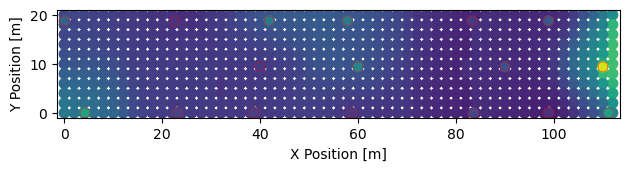

In [7]:
from data.tal import TALDataset
import torch

# Model paths
model_paths = [
    "models/saved/final/checkpoints/epoch=99-step=35500.ckpt",
    "models/saved/final_tal/checkpoints/epoch=4-step=2570.ckpt"
    ]

# Load models
models = load_models(model_paths, "cpu")

# Dataset
dataset = TALDataset("data/tal", environmental_param="gas", type="test", p_sensor=1) 
data = dataset.get_by_timestamp(datetime(2021,9,21,8))

min_data = data.x[~torch.any(data.x.isnan(),dim=1)].min()
max_data = data.x[~torch.any(data.x.isnan(),dim=1)].max()
print(f"min: {min_data}")
print(f"max: {max_data}")

# Predict with all models
predictions = {}
with torch.no_grad():
    for i, model in enumerate(models):
        predictions[f"model_{i}"] = model(data.to("cpu"))

# Determine global min and max values
# vmin = min([pred.min().item() for pred in predictions.values()] + [data.x.min().item()])
# vmax = max([pred.max().item() for pred in predictions.values()] + [data.x.max().item()])
# vmin = torch.round(min_data, decimals=2)
# vmax = torch.round(max_data, decimals=2)
vmin = 0
vmax = 2.3 # based on input data

# Plot results for each model
for i, (name, pred) in enumerate(predictions.items()):
    print(f"{name} min: {pred.min():.3f}, max: {pred.max():.3f}")
    plot_graph(data, pred, vmin=vmin, vmax=vmax, node_size=50)
    plt.savefig(f"figures/tal/{name}_8am.pdf", bbox_inches='tight', pad_inches=0)